<a href="https://www.kaggle.com/code/nminhquang380/image-classification-cat-and-dog?scriptVersionId=141523077" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_380.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_517.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_364.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_258.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_237.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_476.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_563.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_159.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_464.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_518.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_141.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_398.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_442.jpg
/kaggle/input/cats-and-dogs-image-classification/test/dogs/dog_443.jpg
/kaggl

## Libraries

In [2]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import pandas as pd

## Dataset Class

## Lazy Dataset Class

In [3]:
import torchvision.transforms as transforms

class ImageDatasetLoad(Dataset):
    def __init__(self, root_dir, train_mode):
        self.root_dir = root_dir
        self.classes = os.listdir(root_dir)
        
        self.images = []
        self.labels = []
        path_classes = []
        
        for class_dir in self.classes:
            path_classes.append(os.path.join(root_dir, class_dir))
            
        for i, path in enumerate(path_classes):
            for image_file in os.listdir(path):
                image_path = os.path.join(path, image_file)
                
                try:
                    image = Image.open(image_path)
                    image = torch.Tensor(np.array(image))

                    # We need to move the dimensions around from [H, W, C] to [C, H, W]
                    # since the transformation function expects the images to have
                    # shape [C, H, W] also 2D CNN layers expect images to be in this shape 
                    # as well.
                    image = image.permute(2,0,1)

                    self.images.append(image)
                    self.labels.append(i)
                except RuntimeError:
                    pass
                
        self.train_transforms = transforms.Compose([
                                transforms.Resize(224),
                                transforms.RandomCrop(224),
        ])
        self.train_mode = train_mode
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Here we apply the transformations to the pytorch image tensor
        if self.train_mode:
            image = self.train_transforms(image)

        return image, label
    
    def get_class_name(self, class_idx):
        return self.classes[class_idx]

    def get_all_class_names(self):
        return self.classes

                

## Split and Load Dataset

In [4]:
dataset = ImageDatasetLoad('/kaggle/input/cats-and-dogs-image-classification/train', train_mode=True)
test_dataset = ImageDatasetLoad('/kaggle/input/cats-and-dogs-image-classification/test', train_mode=True)

In [5]:
dataset.get_all_class_names()

['dogs', 'cats']

In [6]:
from torch.utils.data import random_split

train_dataset, val_dataset = random_split(dataset, [0.8, 0.2])

In [7]:
print(len(train_dataset), len(val_dataset), len(dataset))

445 111 556


In [8]:
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

test_loader = DataLoader(test_dataset, batch_size=16)

## Plot some images

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


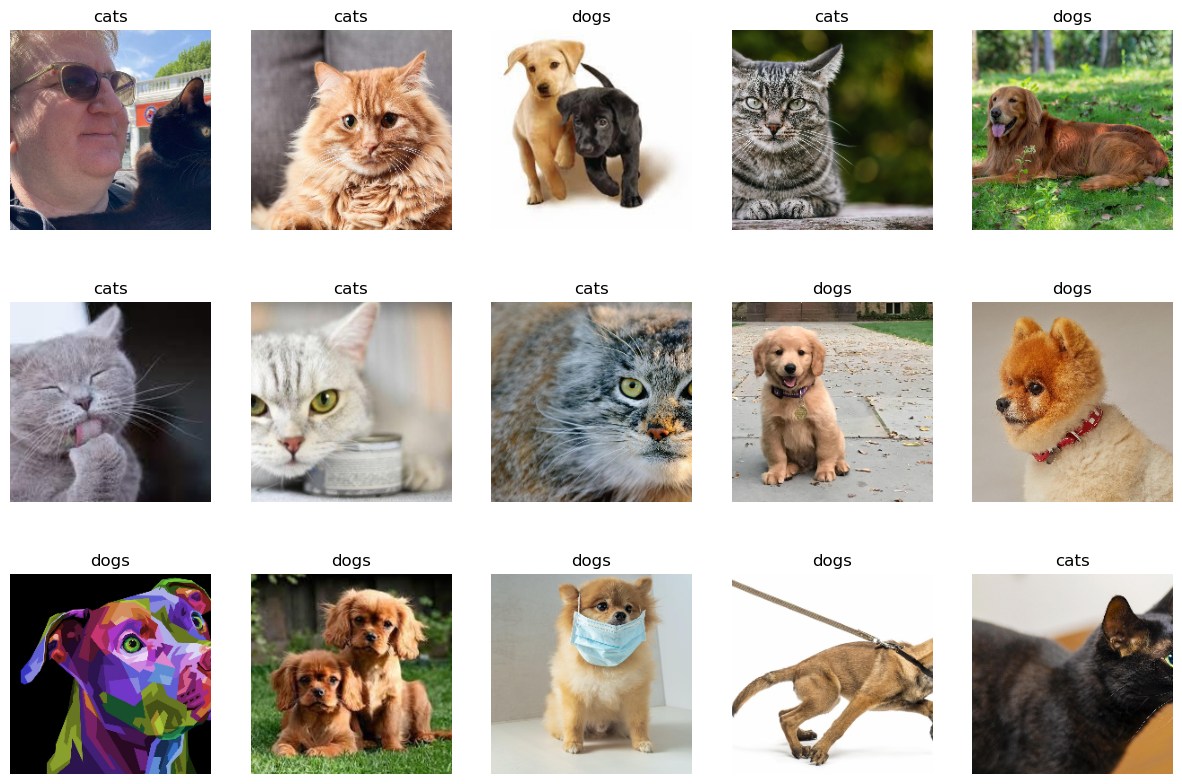

In [9]:
def plot_images(images, labels, class_name):
    plt.figure(figsize=(15, 10))
    num_imgs = min(15, len(images))
    for i in range(num_imgs):
        ax = plt.subplot(3, 5, i+1)
        img = images[i].numpy()
        img = np.transpose(img,(1,2,0))
        
        img -= np.min(img)
        img /= (np.max(img) - np.min(img))
        
        plt.imshow(img)
        plt.title(class_name[labels[i]])
        plt.axis('off')
        
#         break
        
images, labels = next(iter(train_loader))
# print(images, labels)
plot_images(images, labels, ['dogs', 'cats'])

## Set up for Training

In [10]:
import torch
device = torch.device("cpu")

if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)

print("Training on", device)

Training on cuda:0


## Model Class

In [11]:
import torch.nn as nn

class CNNModel(nn.Module):
    def __init__(self, device):
        super(CNNModel, self).__init__()
        
        self.cnn_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(32),
            nn.ReLU(),
#             nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),
            
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout2d(0.25),
            
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=0),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),
        )
        
        self.linear_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(86528, 64),
            nn.ReLU(),
#             nn.Dropout(0.5),
            
            nn.Linear(64, 1),
            nn.Sigmoid(),
        )
        
        self.to(device)
        
    def forward(self, x):
        x = self.cnn_layers(x)
#         print(x.shape)
        x = self.linear_layers(x)
        return x

In [12]:
model = CNNModel(device)
images, labels = next(iter(train_loader))
images, labels = images.to(device), labels.to(device)

outputs = model(images)
print(outputs.shape, labels.shape)

torch.Size([16, 1]) torch.Size([16])


## Simple Train and Test Loop

In [13]:
!pip install torchmetrics

In [14]:
import torchmetrics
import torch.optim as optim
from tqdm.notebook import tqdm

criteria = nn.BCELoss()
model = CNNModel(device)
optim = optim.Adam(model.parameters(), lr=0.003)
metric = torchmetrics.classification.BinaryAccuracy().to(device)
epochs = 10
sigmoid = nn.Sigmoid()

for epoch in tqdm(range(epochs)):
    train_loss = 0
    accuracy = 0
    
    try:
        for batch in train_loader:
            images, labels = batch
            images, labels = images.to(device), labels.to(device)
            
            model.train()

            optim.zero_grad()

            outputs = model(images)
            outputs = outputs.reshape(-1)
            labels = labels.to(torch.float32)

            loss = criteria(outputs, labels)
            train_loss += loss.item()

            loss.backward()
            optim.step()

            acc = metric(outputs, labels)


        print('epoch: %d loss: %.3f' % (epoch + 1, train_loss / len(train_loader)))
        print('epoch: %d accuracy: %.3f' % (epoch + 1, metric.compute()))    

        metric.reset()
        
    except RuntimeError:
        pass
    
    for batch in val_loader:
        images, labels = batch
        images, labels = images.to(device), labels.to(device)
        
        model.eval()
        
        with torch.no_grad():
            outputs = model(images)
            outputs = sigmoid(outputs.reshape(-1))
            labels = labels.to(torch.float32)

        acc = metric(outputs, labels)
        
    print('epoch: %d validation accuracy: %.3f' % (epoch + 1, metric.compute()))
    metric.reset()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

  0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


epoch: 1 loss: 50.832
epoch: 1 accuracy: 0.472
epoch: 1 validation accuracy: 0.577
epoch: 2 loss: 51.597
epoch: 2 accuracy: 0.483
epoch: 2 validation accuracy: 0.577
epoch: 3 loss: 51.700
epoch: 3 accuracy: 0.483
epoch: 3 validation accuracy: 0.577
epoch: 4 loss: 51.700
epoch: 4 accuracy: 0.483
epoch: 4 validation accuracy: 0.577
epoch: 5 loss: 51.545
epoch: 5 accuracy: 0.483
epoch: 5 validation accuracy: 0.577
epoch: 6 loss: 51.700
epoch: 6 accuracy: 0.483
epoch: 6 validation accuracy: 0.577
epoch: 7 loss: 51.854
epoch: 7 accuracy: 0.483
epoch: 7 validation accuracy: 0.577
epoch: 8 loss: 51.700
epoch: 8 accuracy: 0.483
epoch: 8 validation accuracy: 0.577
epoch: 9 loss: 51.700
epoch: 9 accuracy: 0.483
epoch: 9 validation accuracy: 0.577
epoch: 10 loss: 51.803
epoch: 10 accuracy: 0.483
epoch: 10 validation accuracy: 0.577
